In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# https://www.kaggle.com/plenoi/bdm-gender-predict
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bdm-2021-face/622110140_4_0.jpg
/kaggle/input/bdm-2021-face/612110186_1_1.jpg
/kaggle/input/bdm-2021-face/622110172_1_0.jpg
/kaggle/input/bdm-2021-face/622110154_1_0.jpg
/kaggle/input/bdm-2021-face/602110088_1_0.jpg
/kaggle/input/bdm-2021-face/622110206_4_0.jpg
/kaggle/input/bdm-2021-face/602110088_2_0.jpg
/kaggle/input/bdm-2021-face/622110240_4_0.jpg
/kaggle/input/bdm-2021-face/612110159_3_0.jpg
/kaggle/input/bdm-2021-face/622110210_2_0.jpg
/kaggle/input/bdm-2021-face/612110174_4_0.jpg
/kaggle/input/bdm-2021-face/612110185_1_1.jpg
/kaggle/input/bdm-2021-face/622110140_2_0.jpg
/kaggle/input/bdm-2021-face/622110174_2_1.jpg
/kaggle/input/bdm-2021-face/612110186_2_1.jpg
/kaggle/input/bdm-2021-face/622110172_3_0.jpg
/kaggle/input/bdm-2021-face/622110140_1_0.jpg
/kaggle/input/bdm-2021-face/622110174_3_1.jpg
/kaggle/input/bdm-2021-face/612110174_1_0.jpg
/kaggle/input/bdm-2021-face/602110088_3_0.jpg
/kaggle/input/bdm-2021-face/622110222_2_1.jpg
/kaggle/input/bdm-2021-face/622110

In [2]:
import glob
filename = glob.glob("/kaggle/input/bdm-2021-face/*.*")
filename[0].split("_")

['/kaggle/input/bdm-2021-face/622110140', '4', '0.jpg']

In [3]:
label = np.array([float(item.split("_")[-1].split(".")[0]) for item in filename])

In [4]:
!mkdir train

In [5]:
!mkdir train/male
!mkdir train/female

In [ ]:
# clear delet data
# !rm -rf train/female/*

In [6]:
import shutil 
for i in range(len(label)):
    if label[i] == 0:
        shutil.copy(filename[i], '/kaggle/working/train/male/')
    else:
        shutil.copy(filename[i], '/kaggle/working/train/female/')
       

In [7]:
!mkdir test
!mkdir test/male
!mkdir test/female

In [8]:
import glob
filemale = glob.glob("./train/male/*.*")
filefemale = glob.glob("./train/female/*.*")


In [9]:
midx = np.random.randint(len(filemale), size = 4)
fidx = np.random.randint(len(filefemale), size = 2)

In [10]:
for i in fidx:
    shutil.move(filefemale[i],'./test/female/')
for i in midx:
    shutil.move(filemale[i],'./test/male/')

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        #rescale = 1.0/255.0,   # Intensity Normalized
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False,   # randomly flip images
        validation_split=0.2)

2021-09-14 08:45:59.313621: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [12]:
train_dir = './train'
batch_size = 5
img_height = 100 
img_width  = 100
train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = data_generator.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 63 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


In [13]:
train_generator.class_indices

{'female': 0, 'male': 1}

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
# preparing the layers in the Convolutional Deep Neural Network
def create_model():
    tf.random.set_seed(0)
    tf.compat.v1.reset_default_graph() # Clear Model
    model = Sequential()
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = train_generator.image_shape))
    model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu'))
    model.add(Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dropout(rate = 0.1))
    model.add(Dense(units = 16, activation = 'relu'))
    model.add(Dropout(rate = 0.1))
    model.add(Dense(units = 8, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'sigmoid'))
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [15]:
model = create_model()
fitted_model = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 100)

2021-09-14 08:46:21.835748: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-09-14 08:46:21.839500: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-09-14 08:46:21.892324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-14 08:46:21.893308: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-09-14 08:46:21.893400: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-09-14 08:46:21.924944: I tensorflow/stream_executor/platform/def

Epoch 1/100


2021-09-14 08:46:24.818440: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-09-14 08:46:25.869275: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-09-14 08:46:25.913215: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


12/12 [==============================] - 11s 392ms/step - loss: 6.2084 - accuracy: 0.6677 - val_loss: 0.5459 - val_accuracy: 0.8667
Epoch 2/100
12/12 [==============================] - 4s 319ms/step - loss: 0.5483 - accuracy: 0.7856 - val_loss: 0.6196 - val_accuracy: 0.6667
Epoch 3/100
12/12 [==============================] - 4s 335ms/step - loss: 0.5548 - accuracy: 0.7782 - val_loss: 0.2566 - val_accuracy: 0.8667
Epoch 4/100
12/12 [==============================] - 4s 376ms/step - loss: 1.2463 - accuracy: 0.6609 - val_loss: 0.6372 - val_accuracy: 0.7333
Epoch 5/100
12/12 [==============================] - 4s 347ms/step - loss: 0.5526 - accuracy: 0.8803 - val_loss: 0.6006 - val_accuracy: 0.8000
Epoch 6/100
12/12 [==============================] - 4s 371ms/step - loss: 0.4628 - accuracy: 0.8347 - val_loss: 0.5968 - val_accuracy: 0.8000
Epoch 7/100
12/12 [==============================] - 4s 363ms/step - loss: 0.4945 - accuracy: 0.7387 - val_loss: 0.5912 - val_accuracy: 0.7333
Epoch 8/10

In [16]:
import glob
filefemale = glob.glob("./test/female/*.*")
filemale = glob.glob("./test/male/*.*")

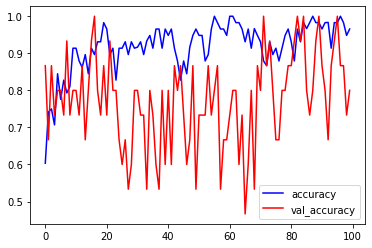

In [20]:
import matplotlib.pyplot as plt
# plotting accuracy and validation accuracy
accuracy = fitted_model.history['accuracy']
val_accuracy = fitted_model.history['val_accuracy']
plt.plot(range(len(accuracy)), accuracy, 'b-', label = 'accuracy')
plt.plot(range(len(val_accuracy)), val_accuracy, 'r-', label = 'val_accuracy')
plt.legend()

In [17]:
from tensorflow.keras.preprocessing import image
# testing the model
plabel = []
for filename in filefemale:
    test_image = image.load_img(filename, target_size = (img_height, img_width))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    plabel.append(np.round(model.predict(test_image)[0][0]))
plabel = np.array(plabel)
sum(plabel==0)/len(plabel)

1.0

In [18]:
plabel = []
for filename in filemale:
    test_image = image.load_img(filename, target_size = (img_height, img_width))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    plabel.append(np.round(model.predict(test_image)[0][0]))
plabel = np.array(plabel)
sum(plabel==1)/len(plabel)

1.0